In [1]:
import matplotlib.pyplot as plt
import numpy as np
import configparser

# just to overwrite default colab style
plt.style.use('default')
plt.style.use('seaborn-talk')

np.random.seed(10)

In [2]:
# Activations
def relu(X):
    return np.maximum(0,X)

def softmax(X):
    exp_x = np.exp(X)
    probs = exp_x / np.sum(exp_x, axis=1, keepdims=True) # [N x K]
    return probs

def batchloader(X, Y, batchsize = 32):
    n = Y.shape[0]
    idx = np.random.choice(np.arange(n),size=batchsize,replace=False)
    X_batch = X[idx,:]
    Y_batch = Y[idx,:]
    
    return X_batch, Y_batch

def crossEntropy(X, Y, W):
    n, m = X.shape
    n, p = Y.shape 
    fce = 0
    network = forward(X, W)
    Y_pred = network[-1]
    Y_pred = np.asarray(Y_pred)
    
    for i in range(n):
        fce += np.dot(Y[i].T, np.log(Y_pred[i]))  
    fce *= (-1/n)
    return fce

def accuracy(Y_pred, Y):
    n,p = Y.shape
    acc = np.sum([np.argmax(Y_pred[i])==np.argmax(Y[i]) for i in range(n)])/(0.01*n)
    return acc

# Storing all weights ndarray as list
def get_weights(layers):
    weights = []
    Nlayers = len(layers)
    c = 10**(-0.5)
    low = -c/2
    high = c/2
    
    for i in range(Nlayers - 1):   
        w = np.random.uniform(low=low, high=high, size=(layers[i],layers[i+1]))
        w[-1] = 0.01   
        weights.append(w)    
    return weights

def forward(X, W):
    h = X  #h0 = X
    network = [X]
    
    for w in W[:-1]:   # in => h1 => out
        z = np.dot(h, w) # next layer
        h = relu(z)      # ReLU activation
        network.append(h)    
    y_pred = softmax(np.dot(h, W[-1])) # output with softmax
    network.append(y_pred)
    
    return network # h1, h2, ... y_hat

def backprop(network, y, W, lr=0.01, alpha = 0.0001):
    y_pred = network[-1]
    dJ_dz = (y - y_pred) #*sigmoidPrime(y_pred) # Initial dJ_dz (deltas)
    
    n = len(network)
    N = range(n)
    dw = []
    
    for i in list(reversed(N))[:-1]:
        dW = network[i-1].T.dot(dJ_dz) # (40, 10) , (785, 40)
        dw.append(dW) # (785,40) (40,10) 
        dJ_dz = dJ_dz.dot(W[i-1].T) # (128,10), (128,40)      
        dJ_dz[network[i-1] <= 0] = 0
        
    dw = np.flip(np.asarray(dw))
    for i in range(n-1):
        Wreg = W[i]
        Wreg[-1] = 0*Wreg[-1]
        W[i] += lr*dw[i] + alpha*Wreg
    return W 

def SGD(X, Y, layers, learning_rate=0.1, epochs=100, bs = 32, alpha = 0.002 ):

    n, m = X.shape
    n, p = Y.shape
    
    # Initialize Weights
    weights = get_weights(layers)

    COST = np.zeros(epochs)
    ACC = np.zeros(epochs)
    
    for i in range(epochs):
        
        # Get Batch 
        X_batch, Y_batch = batchloader(X, Y, bs) 
        
        # Forward Pass
        network = forward(X_batch,weights)

        # Back Propagation
        weights = backprop(network, Y_batch, weights, learning_rate, alpha)    

        # get cost
        COST[i] = crossEntropy(X_batch, Y_batch, weights)
        Y_pred = forward(X_batch, weights)[-1]
        acc = accuracy(Y_pred, Y_batch)
        ACC[i] = acc  
        
    return weights, COST, ACC 

In [3]:
def findBestHyperparameters():
    print('Tuning Hyperparameter . . .')
    # Load data
    Xtr = np.load("mnist_train_images.npy")
    n,m = Xtr.shape
    Xtr = Xtr.reshape((n,-1))

    # preprocessing Data
    Xtr = np.append(Xtr, np.ones((n,1)), axis=1)
    n,m = Xtr.shape

    Ytr = np.load("mnist_train_labels.npy")
    p = Ytr.shape[1]

    # Get Validation Set
    Xv = np.load("mnist_validation_images.npy")
    nv = Xv.shape[0]
    Xv = Xv.reshape((nv,-1)) # feature vector is row vector 

    # preprocessing on validation set 
    Xv = np.append(Xv, np.ones((nv,1)), axis=1)

    Yv = np.load("mnist_validation_labels.npy")

    # Tune Hyper parameter
    LR = [0.001, 0.01, 0.1, 0.5]
    EPOCHS = [25, 50, 75, 100]
    BATCHSIZE = [16, 32, 64, 128]
    ALPHA = [0.000001, 0.000002, 0.00005, 0.00001]

    # Define layers: Input Hidden Output
    # Enter no. of perceptrons in each layer
    layers = [m] + [40] + [p]

    cost = 1000000
    iter = 0

    for lr_ in LR:
        for epochs_ in EPOCHS:
            for bs_ in BATCHSIZE:
                for alpha_ in ALPHA:
                    theta, COST, ACC = SGD(Xtr, Ytr, layers, learning_rate=lr_, epochs=epochs_, bs=bs_, alpha=alpha_) 
                    loss = COST[-1]
                    print("iter: ", iter, "accuracy: ", ACC[-1], ", loss: ", COST[-1])
                    iter += 1 

                    if(loss<cost):
                        lr = lr_
                        epochs = epochs_
                        bs = bs_
                        alpha = alpha_
                        cost=loss

    print('Hyperparameter tuning completed:')
    print('learning rate: ', lr, ', Epochs: ', epochs, ', mini-batchsize: ', bs, ', alpha: ', alpha)
    return layers, lr, epochs, bs, alpha

Testing model . . .


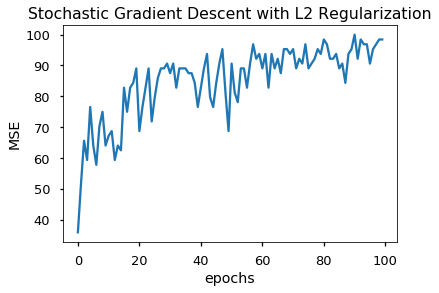

Results: 
accuracy (mean over last 10 samples): 96.40625
Cross entropy loss on test data:  0.3201685067841064
Tuned Hyperparameters: 
learning rate:  0.01 , Epochs:  100 , mini-batchsize (in %):  64 , alpha:  2e-06


In [45]:
# Load data
Xtr = np.load("mnist_train_images.npy")
n,m = Xtr.shape
Xtr = Xtr.reshape((n,-1))

# preprocessing Data
Xtr = np.append(Xtr, np.ones((n,1)), axis=1)
n,m = Xtr.shape

Ytr = np.load("mnist_train_labels.npy")
p = Ytr.shape[1]

# Get Validation Set
Xv = np.load("mnist_validation_images.npy")
nv = Xv.shape[0]
Xv = Xv.reshape((nv,-1)) # feature vector is row vector 

# preprocessing on validation set 
Xv = np.append(Xv, np.ones((nv,1)), axis=1)

Yv = np.load("mnist_validation_labels.npy")

# layers, lr, epochs, bs, alpha = findBestHyperparameters()

print('Testing model . . .')
# Training on tuned hyperparameters
theta, COST, ACC = SGD(Xtr, Ytr, layers, learning_rate=lr, epochs=epochs, bs=bs, alpha=alpha)

plt.plot(ACC)
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('Stochastic Gradient Descent with L2 Regularization')
plt.show()

# Testing 
X_te = np.load("mnist_test_images.npy")
n = X_te.shape[0]
X_te = X_te.reshape((n,-1))

# preprocessing Data
X_te = np.append(X_te, np.ones((n,1)), axis=1)
yte = np.load("mnist_test_labels.npy")

CE = crossEntropy(X_te, yte, theta)

print('Results: ')
print('accuracy (mean over last 10 samples):', np.mean(ACC[-10:]))
print('Cross entropy loss on test data: ', CE)
print('Tuned Hyperparameters: ')
print('learning rate: ', lr, ', Epochs: ', epochs, ', mini-batchsize (in %): ', bs, ', alpha: ', alpha)